In [1]:
## Notebook to check the flow separation between north and south arms of Fraser river in the new bathymetry
%matplotlib notebook
import matplotlib.pyplot as plt
import netCDF4 as nc
import os,sys,fnmatch,time
import numpy as np
import numpy.ma as ma
sys.path.append('/home/mdunphy/analysis-michael/scDataset')
sys.path.append('/home/mdunphy/analysis-michael/bathymetry')
from scDataset import scDataset
from bathy_helpers import *
import utils

with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea3.nc', 'r') as cnc:
    glamf = cnc.variables['glamf'][0,...]; gphif = cnc.variables['gphif'][0,...]
    glamt = cnc.variables['glamt'][0,...]; gphit = cnc.variables['gphit'][0,...]
    glamfe, gphife = expandf(glamf, gphif)

with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', 'r') as bnc:
    bathy = bnc.variables['Bathymetry'][:]

with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc', 'r') as mnc:
    e3t_0 = mnc.variables['e3t_0'][0,...]
    e3u_0 = mnc.variables['e3u_0'][0,...]
    e3v_0 = mnc.variables['e3v_0'][0,...]
    e1t = mnc.variables['e1t'][0,...]
    e1u = mnc.variables['e1u'][0,...]
    e1v = mnc.variables['e1v'][0,...]
    e2t = mnc.variables['e2t'][0,...]
    e2u = mnc.variables['e2u'][0,...]
    e2v = mnc.variables['e2v'][0,...]
    tmask = mnc.variables['tmask'][0,...]
    umask = mnc.variables['umask'][0,...]
    vmask = mnc.variables['vmask'][0,...]
    
def gethourlyfiles(prefix, days, grid):
    files = []    
    for day in days:
        dirname = os.path.join(prefix, day)
        for item in os.listdir(dirname):
            if fnmatch.fnmatchcase(item, "SalishSea_1h_*"+grid+"*.nc"):
                files += [os.path.join(dirname,item)]
    return files

prefix='/results/SalishSea/hindcast/'
days = ['{:02d}sep14'.format(x) for x in range(12,28+1)]
filesT = gethourlyfiles(prefix, days, 'grid_T')
filesU = gethourlyfiles(prefix, days, 'grid_U')
filesV = gethourlyfiles(prefix, days, 'grid_V')
#filesW = gethourlyfiles(prefix, days, 'grid_W')

<IPython.core.display.Javascript object>


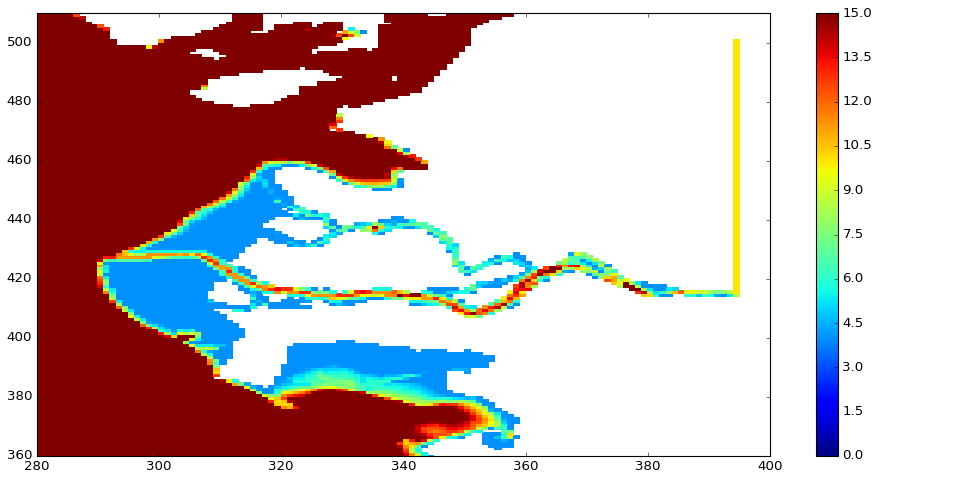

In [2]:
plt.figure(figsize=(12,6)); im=plt.pcolormesh(bathy); cbmax=15
cb=plt.colorbar(im); im.set_clim([0,cbmax]); cb.set_clim(0,cbmax);
plt.gca().set_xlim(280,400)
plt.gca().set_ylim(360,510)
plt.tight_layout(pad=0.5)

In [3]:
def volu(SY,SX):
    eta = dsT.variables['sossheig'][:,SY,SX][:,np.newaxis,:]
    u = dsU.variables['vozocrtx'][:,:,SY,SX]
    Hu=np.sum( e3u_0[:,SY,SX]*umask[:,SY,SX],0)[np.newaxis,:]
    Hu[Hu==0]=1e20
    F=np.sum(np.sum(e3u_0[np.newaxis,:,SY,SX]*(1+eta/Hu)*umask[:,SY,SX]*u*e2u[SY,SX],1),1)
    return F

def volv(SY,SX):
    eta = dsT.variables['sossheig'][:,SY,SX][:,np.newaxis,:]
    v = dsV.variables['vomecrty'][:,:,SY,SX]
    Hv=np.sum( e3v_0[:,SY,SX]*vmask[:,SY,SX],0)[np.newaxis,:]
    Hv[Hv==0]=1e20
    F=np.sum(np.sum(e3v_0[np.newaxis,:,SY,SX]*(1+eta/Hv)*vmask[:,SY,SX]*v*e1v[SY,SX],1),1)
    return F

In [4]:
with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesV) as dsV:
    t=dsT.variables['time_counter'][:]
    t-=t[0]
    t/=(3600*24)
    F3=volv(490,slice(390,397))   # Near start ("Hope")
    F2=volu(slice(400,440),390)   # Slightly west of the 'corner'
    F1=volu(slice(400,440),364)   # Just before we split into two arms
    Fs=volu(slice(406,420),330)   # South arm
    Fn=volu(slice(430,445),330)   # North arm

In [5]:
# Apply a sliding mean (width two tidal periods) to each
E1,E2,E3,En,Es = tuple(map(lambda x: utils.slidingmean(t,x,2*44712/86400),[F1,F2,F3,Fn,Fs]))

In [6]:
riverdir='/home/mdunphy/rivers_R201702/'
rfiles = []
for item in os.listdir(riverdir):
    if fnmatch.fnmatchcase(item, "R2017*.nc"):
        rfiles += [os.path.join(riverdir,item)]
rfiles = sorted(rfiles)[1:-1]  # CAUTION: Fragile; dropping m09d11 and m09d29
#for f in rfiles: print(f)
SX,SY = slice(390,397), slice(490,510)  # square encompassing "Hope"
with scDataset(rfiles) as dsr:
    tmp = dsr.variables['rorunoff'][:,SY,SX]   # runoff file says kg m^-2 s^-1
inw = tmp * tmask[0,SY,SX] * e1t[SY,SX] * e2t[SY,SX] / 1000.0  # this should be m^3 s^-1
flux = np.sum(np.sum(inw,1),1) # reduce to time series
tr = t[slice(12, len(t), 24)]  # Use middle-of-day from main t time vector

<IPython.core.display.Javascript object>


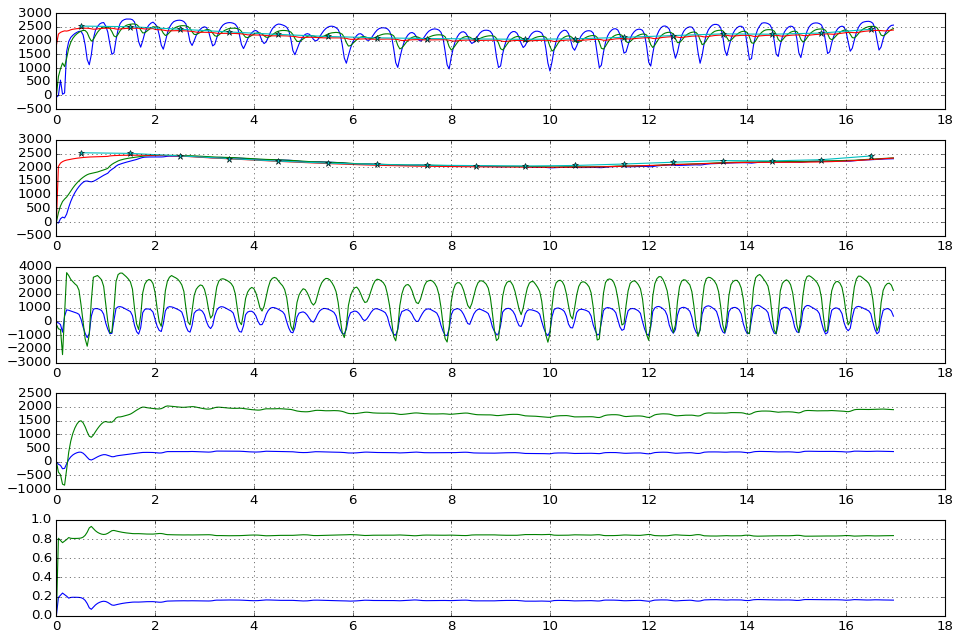

In [8]:
plt.figure(figsize=(12,8));
plt.subplot(5,1,1); plt.plot(t,-F1,t,-F2,t,-F3,tr,flux,'-*'); plt.grid(True)
plt.subplot(5,1,2); plt.plot(t,-E1,t,-E2,t,-E3,tr,flux,'-*'); plt.grid(True)

plt.subplot(5,1,3); plt.plot(t,-Fn,t,-Fs); plt.grid(True)
plt.subplot(5,1,4); plt.plot(t,-En,t,-Es); plt.grid(True)

rs=Es/(En+Es+1e-20)
rn=En/(En+Es+1e-20)
plt.subplot(5,1,5); plt.plot(t,rn,t,rs); plt.grid(True)

plt.tight_layout(pad=0.5)